In [3]:
#!pip install gymnasium
#!pip install gym-notices

In [4]:
import gymnasium as gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)
plt.style.use('seaborn-v0_8')
import copy
from tqdm.notebook import tqdm

from common import ReplayBuffer, Critic, SoftActor
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda:0" if torch.cuda.is_available() else
                      "cpu")
device = torch.device("cpu")    # actually faster than mps

results = {}

## Algorithm: Soft Actor-Critic (SAC)
Implementation based on the [original paper](https://arxiv.org/abs/1801.01290), Open AI's [Spinning Up](https://spinningup.openai.com/en/latest/algorithms/sac.html#), [Stable-Baselines3](https://github.com/DLR-RM/stable-baselines3/tree/master) and [this repository](https://github.com/pranz24/pytorch-soft-actor-critic)

to try:
* Scheduler 
* [Stable Baselines3 hyperparameters](https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/sac.yml)

In [5]:
"""
Hyperparameters
---------------           # [description]
"""
ALPHA = 0.4
BATCH_SIZE = 256          # for off policy updates
DISCOUNT = 0.98           # discount factor (gamma)
TAU = 0.001               # target network update rate
START_TIME = int(1e4)     # pure exploration steps
ENV_STEP_FREQ = 1
GRADIENT_STEP_FREQ = 1
TARGET_UPDATE_PERIOD = 1
HIDDEN_DIM = 64          # of actor and critic networks
LEARNING_RATE = 1e-3      # of actor and critic networks
BUFFER_SIZE = 1e6

"""
Algorithm
---------
Soft Actor-Critic
"""
def SAC(env, max_t=int(1e4), n_episodes=2000):

    # all classical control envs have continuous states
    state_dim = env.observation_space.shape[0]

    # check if action space is discrete
    discrete_actions = isinstance(env.action_space, gym.spaces.Discrete)
    if discrete_actions:
        action_dim = env.action_space.n
        min_action = 0
        max_action = env.action_space.n - 1
        actor = DiscreteActor(state_dim, action_dim, HIDDEN_DIM).to(device)

    else:   # continuous action space
        action_dim = env.action_space.shape[0]
        assert env.action_space.low.shape == (1,), 'env has action_dim > 1'
        min_action = env.action_space.low[0]
        max_action = env.action_space.high[0]
        actor = SoftActor(state_dim, action_dim, min_action, max_action, HIDDEN_DIM).to(device)

    target_actor = copy.deepcopy(actor).to(device)
    actor_optimizer = torch.optim.Adam(actor.parameters(), lr=LEARNING_RATE)

    critic_1 = Critic(state_dim, action_dim, HIDDEN_DIM).to(device)
    critic_2 = Critic(state_dim, action_dim, HIDDEN_DIM).to(device)
    target_critic_1 = copy.deepcopy(critic_1).to(device)
    target_critic_2 = copy.deepcopy(critic_2).to(device)
    critic_optimizer = torch.optim.Adam(
        list(critic_1.parameters()) + list(critic_2.parameters()),
        lr=LEARNING_RATE)

    replay_buffer = ReplayBuffer(state_dim, action_dim, BUFFER_SIZE)

    gradient_updates = 0    # for target network update period

    step = 0
    episode = 1
    episodes_reward = []    # reward of each episodes
    episode_reward = 0      # reward of the current episode
    cumulative_rewards_t = [0]

    # for debug purposes
    critic_losses = []
    actor_losses = []

    state = env.reset()[0]
    
    episodes_pbar = tqdm(total=n_episodes, position=1)
    episodes_pbar.set_description("Episodes")
    steps_pbar = tqdm(total=max_t, position=0)
    steps_pbar.set_description("Timesteps")
    while step < max_t and episode <= n_episodes:
        for env_step in range(ENV_STEP_FREQ):
            with torch.no_grad():
                if step < START_TIME:
                    # Start by exploration
                    a = env.action_space.sample()  # outputs (1,) array in continuous envs
                    if discrete_actions:
                        action = F.one_hot(torch.tensor([a]), num_classes=action_dim)
                    else:
                        action = torch.from_numpy(a)    # to store in the ReplayBuffer
                else:
                    action = actor.act( torch.from_numpy(state).reshape(1,-1).to(device) )
                    if discrete_actions:    # Gymnasium expects a single value in this case
                        a = torch.argmax(action, dim=1).item()
                    else:                   # and a (1,) array in continous envs
                        a = action.flatten()
                
                # Execute action and observe
                next_state, reward, terminated, truncated, _ = env.step(a)
                done = terminated or truncated
                episode_reward += reward
                cumulative_rewards_t.append(cumulative_rewards_t[-1] + reward)

                # Store tuple in replay buffer
                replay_buffer.add_entry(state, action, reward, next_state, done)

                # If s' is terminal, reset environment
                if done:
                    state = env.reset()[0]
                    episode += 1
                    episodes_pbar.update(1)
                    episodes_pbar.refresh()
                    episodes_reward.append(episode_reward)
                    episode_reward = 0
                    if episode >= n_episodes:
                        break

                else:
                    state = next_state
                
                step += 1
                steps_pbar.update(1)

        # Training 
        if step > START_TIME:
            for gradient_step in range(GRADIENT_STEP_FREQ):
                replay_state, replay_action, replay_reward, replay_next_state, replay_done = replay_buffer.sample(BATCH_SIZE)
            
                with torch.no_grad():   # no autograd for target networks
                    # Select action with noise
                    next_action, next_log_pi, _ = actor.sample(replay_next_state)
                    # Compute target Q values
                    target_Q1 = target_critic_1(replay_next_state, next_action)
                    target_Q2 = target_critic_2(replay_next_state, next_action)
                    target_Q = torch.minimum(target_Q1, target_Q2) - ALPHA*next_log_pi
                    y = replay_reward + DISCOUNT*(1-replay_done)*target_Q

                # Compute critic loss (gradient descent)
                Q1 = critic_1(replay_state, replay_action)
                Q2 = critic_2(replay_state, replay_action)
                critic_loss = F.mse_loss(Q1, y) + F.mse_loss(Q2, y)

                # Update critics
                critic_optimizer.zero_grad()
                critic_loss.backward()
                critic_optimizer.step()
                critic_losses.append(critic_loss.item())

                # Compute actor loss
                a_pi, log_pi, _ = actor.sample(replay_state)
                q1_pi = critic_1(replay_state, a_pi)
                q2_pi = critic_2(replay_state, a_pi)
                q_pi = torch.minimum(q1_pi, q2_pi)
                actor_loss = torch.mean( (ALPHA*log_pi) - q_pi )

                # Update policy
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()
                actor_losses.append(actor_loss.item())

                gradient_updates += 1
                # Update target networks
                if (gradient_updates % TARGET_UPDATE_PERIOD == 0):
                    for param, target_param in zip(critic_1.parameters(), target_critic_1.parameters()):
                        target_param.data.copy_(TAU*param.data + (1-TAU)*target_param.data)

                    for param, target_param in zip(critic_2.parameters(), target_critic_2.parameters()):
                        target_param.data.copy_(TAU*param.data + (1-TAU)*target_param.data)

                    for param, target_param in zip(actor.parameters(), target_actor.parameters()):
                        target_param.data.copy_(TAU*param.data + (1-TAU)*target_param.data)


    actor_losses = np.repeat(actor_losses, ENV_STEP_FREQ)
    nan_starts = np.empty(START_TIME)
    nan_starts[:] = np.nan
    critic_losses = np.concatenate((nan_starts, critic_losses))
    actor_losses = np.concatenate((nan_starts, actor_losses))
    
    return cumulative_rewards_t[1:], episodes_reward, critic_losses, actor_losses


## Testing: Continuous environments

In [6]:
continuous_envs = ["MountainCarContinuous-v0", "Pendulum-v1"]

from plot_utils import plot_results
import pickle

In [7]:
env_name = continuous_envs[0]   # MountainCarContinous-v0
env = gym.make(env_name)
env.reset(seed=0)

torch.manual_seed(0)

"""
Hyperparameters
---------------           # [description]
"""
ALPHA = 0.2
BATCH_SIZE = 256          # for off policy updates
DISCOUNT = 0.99           # discount factor (gamma)
TAU = 5e-3                # target network update rate
START_TIME = int(5e5)     # pure exploration steps
ENV_STEP_FREQ = 2
GRADIENT_STEP_FREQ = 1
TARGET_UPDATE_PERIOD = 1
HIDDEN_DIM = 64           # of actor and critic networks
LEARNING_RATE = 3e-3      # of actor and critic networks
BUFFER_SIZE = 1e5

N_SEEDS = 1
results[env_name] = []
for seed in [2]:
    env.reset(seed=seed)

    torch.manual_seed(seed)

    rewards_t, episodes_reward, critic_losses, actor_losses = SAC(env, max_t=int(1e6), n_episodes=500)
    results[env_name].append((rewards_t, episodes_reward, critic_losses, actor_losses))

if N_SEEDS >= 3:
    with open(f"sac_{env_name}.obj", 'wb') as f:
        pickle.dump(results[env_name], f)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/bastienmarconato/Developer/reinforcement-learning/EE-568-Project/plot_utils.py:46: RuntimeWarning: Mean of empty slice
  mean_critic_loss = np.nanmean(critic_agg, axis=1)
/Users/bastienmarconato/Developer/reinforcement-learning/EE-568-Project/plot_utils.py:47: RuntimeWarning: Mean of empty slice
  mean_actor_loss = np.nanmean(actor_agg, axis=1)


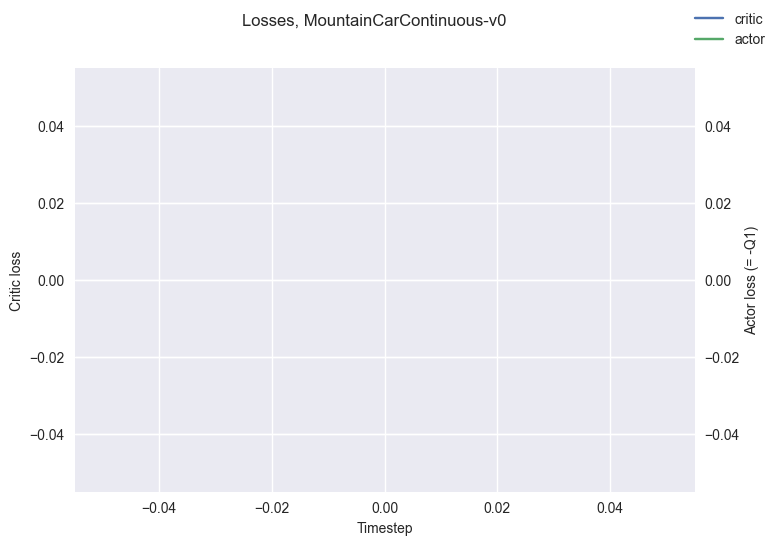

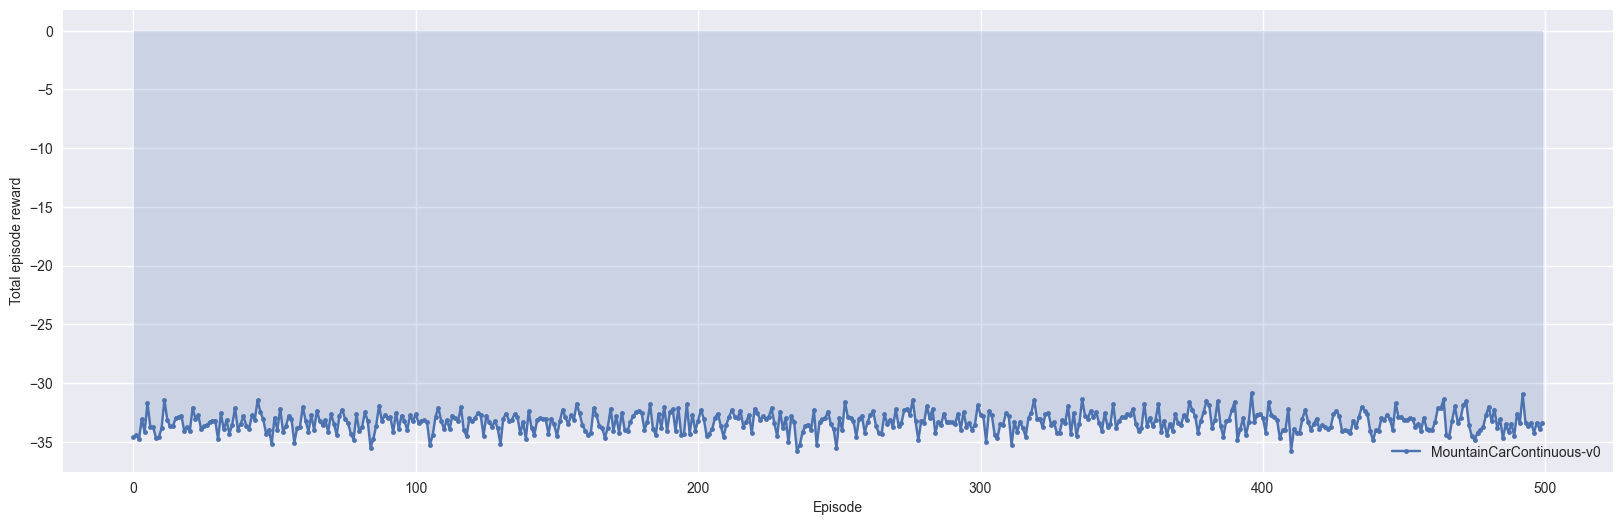

In [8]:
plot_results(results, env_name)

In [7]:
env_name = continuous_envs[1]   # Pendulum-v1
env = gym.make(env_name)
env.reset(seed=0)

torch.manual_seed(0)


"""
Hyperparameters
---------------           # [description]
"""
ALPHA = 0.1
BATCH_SIZE = 128          # for off policy updates
DISCOUNT = 0.99           # discount factor (gamma)
TAU = 0.005               # target network update rate
START_TIME = int(0)       # pure exploration steps
ENV_STEP_FREQ = 2
GRADIENT_STEP_FREQ = 1
TARGET_UPDATE_PERIOD = 1
HIDDEN_DIM = 64           # of actor and critic networks
LEARNING_RATE = 1e-3      # of actor and critic networks
BUFFER_SIZE = 1e4

N_SEEDS = 3
results[env_name] = []
for seed in range(N_SEEDS):
    env.reset(seed=seed)

    torch.manual_seed(seed)

    rewards_t, episodes_reward, critic_losses, actor_losses = SAC(env, max_t=int(1e6), n_episodes=1000)
    results[env_name].append((rewards_t, episodes_reward, critic_losses, actor_losses))

if N_SEEDS >= 3:
    with open(f"sac_{env_name}.obj", 'wb') as f:
        pickle.dump(results[env_name], f)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:246: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'torch.Tensor'>
  logger.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

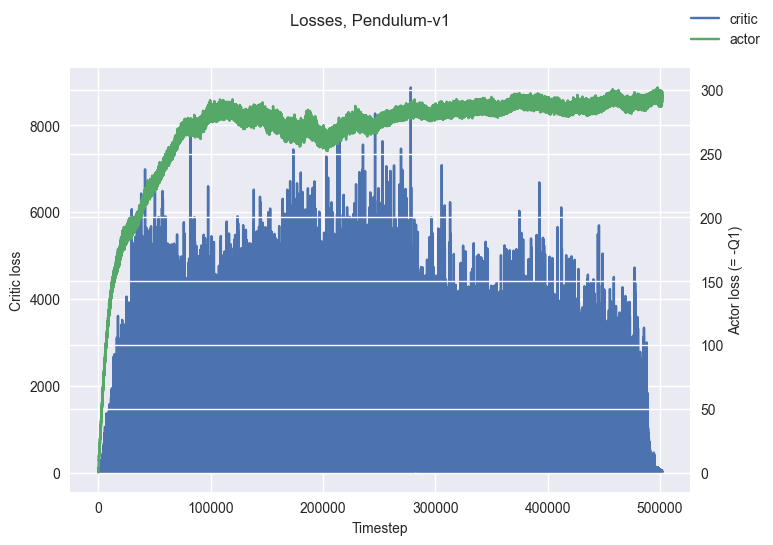

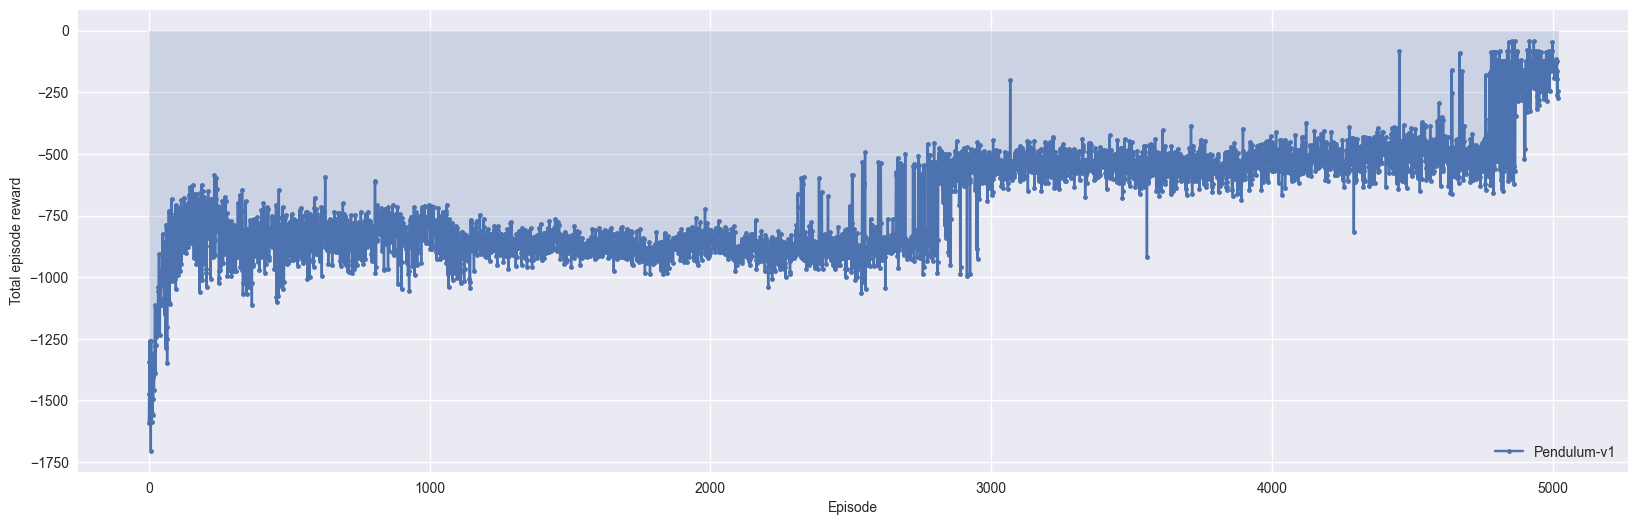

In [8]:
plot_results(results, env_name)